In [1]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from scipy.special import logit

import util

n_i = np.array([20, 20, 35, 35])
y_i = np.array([0, 1, 9, 10], dtype=np.float64)
data = np.stack((y_i, n_i), axis=1)

mu_0 = -1.34
mu_sig_sq = 100.0
logit_p1 = logit(0.3)

## Section 1: compute $p(\sigma^2|y)$

## 1.1: Construct $\sigma^2$ quadrature rule

and compute values dependent only on $\sigma^2$:
* precision matrix for p(\theta | \sigma^2): inverse covariance.
* determinant of precision matrix
* values of the prior.

In [2]:
sigN = 15
sigma2_rule = util.log_gauss_rule(sigN, 1e-6, 1e3)
arms = np.arange(4)
cov = np.full((sigN, 4, 4), mu_sig_sq)
cov[:, arms, arms] += sigma2_rule.pts[:, None]

precQ = np.linalg.inv(cov)
precQdet = np.linalg.det(precQ)
log_prior = scipy.stats.invgamma.logpdf(sigma2_rule.pts, 0.0005, scale=0.000005)

## 1.2: find the maximum of $p(\theta | y, \sigma^2)$

for each value of $\sigma^2$.

In [3]:
tol = 1e-8
theta_max = np.zeros((sigN, 4))
for i in range(100):
    theta_m0 = theta_max - mu_0
    theta_adj = theta_max + logit_p1
    grad = (
        -np.sum(precQ * theta_m0[:, None, :], axis=-1)
        + y_i
        - (n_i * np.exp(theta_adj) / (np.exp(theta_adj) + 1))
    )
    hess = -precQ.copy()
    hess[:, arms, arms] -= n_i * np.exp(theta_adj) / ((np.exp(theta_adj) + 1) ** 2)
    step = -np.linalg.solve(hess, grad)
    theta_max += step

    if np.max(np.linalg.norm(step, axis=-1)) < tol:
        print(i)
        break

11


## 1.3 Laplace approximation for calculating $p(\theta|y)$

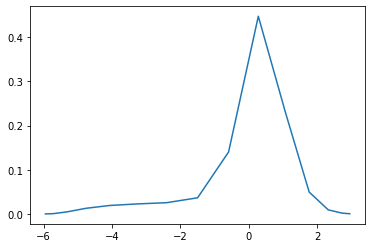

In [4]:
theta_m0 = theta_max - mu_0
theta_adj = theta_max + logit_p1
logjoint = (
    -0.5 * np.einsum("...i,...ij,...j", theta_m0, precQ, theta_m0)
    + 0.5 * np.log(precQdet)
    + np.sum(theta_adj * y_i - n_i * np.log(np.exp(theta_adj) + 1), axis=-1)
    + log_prior
)

# The last step will be sufficiently small that we shouldn't need to update the
# hessian
# hess = -precQ.copy()
# hess[:, arms, arms] -= n_i * np.exp(theta_adj) / ((np.exp(theta_adj) + 1) ** 2)
log_sigma2_post = logjoint - 0.5 * np.log(np.linalg.det(-hess))
# This can be helpful for avoiding overflow.
# log_sigma2_post -= np.max(log_sigma2_post, axis=-1) - 600
sigma2_post = np.exp(log_sigma2_post)
sigma2_post /= np.sum(sigma2_post * sigma2_rule.wts)
plt.plot(np.log10(sigma2_rule.pts), sigma2_post * sigma2_rule.wts)
plt.show()

In [5]:
sigma2_post

array([1.25954474e+02, 4.52520893e+02, 8.66625278e+02, 5.08333300e+02,
       1.30365045e+02, 2.20403048e+01, 3.15183578e+00, 5.50967224e-01,
       2.68365061e-01, 1.23585852e-01, 1.13330444e-02, 5.94800210e-04,
       4.01075571e-05, 4.92782335e-06, 1.41605356e-06])

# Section 2: computing latent variable marginals: $p(\theta_i | y)$


In [9]:
arm_idx = 0
ti_N = 61
ti_rule = util.simpson_rule(ti_N, -6.0, 2.0)
# ti_rule = util.gauss_rule(ti_N, -6.0, 2.0)


## 2.0: Do it with full numerical integration (slow)


In [10]:
import berry
import quadrature

b = berry.Berry()
integrate_dims = [0, 1, 2, 3]
integrate_dims.remove(arm_idx)
quad_p_ti_g_y = quadrature.integrate(
    b,
    data[
        None,
    ],
    integrate_sigma2=True,
    integrate_thetas=integrate_dims,
    fixed_dims={arm_idx: ti_rule},
    n_theta=9,
)
quad_p_ti_g_y /= np.sum(quad_p_ti_g_y * ti_rule.wts, axis=1)[:, None]



## 2.1: Gaussian approximation of $p(\theta_i|y, \sigma^2)$

When we calculated the posterior of the hyperparameters above in section 1.3, we developed a multi-variate normal approximation for $p(\theta|y, \sigma^2)$. We can re-use this approximation now to compute $p(\theta_i | y)$. 

The final step is to evaluate at a range of $\theta_i$ and then integrate over $\sigma^2$.

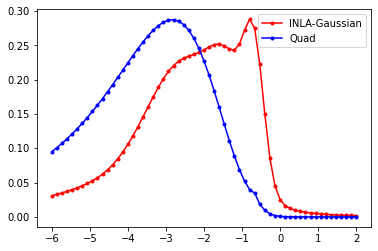

In [11]:
theta_i_sigma = np.sqrt(np.diagonal(-np.linalg.inv(hess), axis1=1, axis2=2))
theta_i_mu = theta_max
gaussian_pdf = scipy.stats.norm.pdf(
    ti_rule.pts[:, None],
    theta_i_mu[None, :, arm_idx],
    theta_i_sigma[None, :, arm_idx],
)
gaussian_p_ti_g_y = np.sum(
    gaussian_pdf * sigma2_post * sigma2_rule.wts[None, :], axis=1
)

plt.plot(ti_rule.pts, gaussian_p_ti_g_y, "r-o", markersize=3, label="INLA-Gaussian")
plt.plot(ti_rule.pts, quad_p_ti_g_y[0], "b-o", markersize=3, label="Quad")
plt.legend()
plt.show()

## 2.2: Laplace approximation of $p(\theta_i|y, \sigma^2)$

Instead of assuming $p(\theta_i|y, \sigma^2)$ is Gaussian, we will compute it using the same Laplace approximation method that we used to compute $p(\sigma^2|y)$. That is:
* we optimize over $\mathbf{\theta}_{-i}$ - the list of $\theta$ indices that are not equal to $i$.
* Then we assume that $p(\mathbf{\theta}_{-i})$ is 


In [50]:
subset_arms = [0, 1, 2, 3]
subset_arms.remove(arm_idx)
# If
# 1) t_{arm_idx} is chosen without regard to the other theta values
# 2) sigma2 is very small
# then, the optimization problem will be poorly conditioned and ugly because the
# chances of t_{arm_idx} being very different from the other theta values is
# super small with small sigma2
ti_max = np.tile(theta_max[None, :, subset_arms], (ti_N, 1, 1))
y_i_sub = y_i[..., subset_arms]
n_i_sub = n_i[..., subset_arms]
precQ_tiled = np.tile(precQ, (ti_N, 1, 1, 1))
for i in range(100):
    ti_all_max = np.zeros((*ti_max.shape[:2], 4))
    ti_all_max[..., subset_arms] = ti_max
    ti_all_max[..., arm_idx] = ti_rule.pts[:, None]

    ti_all_m0 = ti_all_max - mu_0
    ti_adj = ti_max + logit_p1
    ti_grad = (
        -np.sum(precQ_tiled * ti_all_m0[..., None, :], axis=-1)[..., subset_arms]
        + y_i_sub
        - (n_i_sub * np.exp(ti_adj) / (np.exp(ti_adj) + 1))
    )
    ti_hess = -precQ_tiled[..., subset_arms][..., subset_arms, :].copy()
    ti_hess[..., np.arange(3), np.arange(3)] -= (
        n_i_sub * np.exp(ti_adj) / ((np.exp(ti_adj) + 1) ** 2)
    )
    step = -np.linalg.solve(ti_hess, ti_grad)
    ti_max += step

    if np.max(np.linalg.norm(step, axis=-1)) < tol:
        print(i)
        break

5


In [51]:
ti_all_max = np.zeros((*ti_max.shape[:2], 4))
ti_all_max[..., subset_arms] = ti_max
ti_all_max[..., arm_idx] = ti_rule.pts[:, None]

ti_all_m0 = ti_all_max - mu_0
ti_adj = ti_all_max + logit_p1
ti_logjoint = (
    -0.5 * np.einsum("...i,...ij,...j", ti_all_m0, precQ, ti_all_m0)
    + 0.5 * np.log(precQdet)[None, :]
    + np.sum(ti_adj * y_i - n_i * np.log(np.exp(ti_adj) + 1), axis=-1)
    + log_prior[None, :]
)

In [52]:
ti_hess = -precQ_tiled[..., subset_arms][..., subset_arms, :].copy()
ti_hess[..., np.arange(3), np.arange(3)] -= (
    n_i_sub
    * np.exp(ti_adj[..., subset_arms])
    / ((np.exp(ti_adj[..., subset_arms]) + 1) ** 2)
)
ti_post = np.exp(ti_logjoint - 0.5 * np.log(np.linalg.det(-ti_hess)))
ti_post /= np.sum(ti_post * ti_rule.wts[:, None], axis=0)
laplace_p_ti_g_y = np.sum(ti_post * sigma2_post * sigma2_rule.wts, axis=1)

# Section 3: Treat a single arm directly?

What if we *always* analytically integrate arm 0? Both in the computation of $p(\sigma^2|y)$ and in computing $p(\theta_0|y)$?

This is actually quite easy given the calculations already done above. 

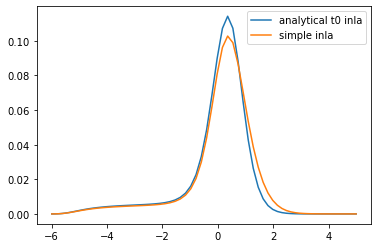

In [53]:
new = np.sum(
    np.exp(ti_logjoint - 0.5 * np.log(np.linalg.det(-ti_hess))) * ti_rule.wts[:, None],
    axis=0,
)
new /= np.sum(new * sigma2_rule.wts)
plt.plot(np.log10(sigma2_rule.pts), new * sigma2_rule.wts, label="analytical t0 inla")
plt.plot(np.log10(sigma2_rule.pts), sigma2_post * sigma2_rule.wts, label="simple inla")
plt.legend()
plt.show()

In [54]:
t0_analytical_p_ti_g_y = np.sum(ti_post * new * sigma2_rule.wts, axis=1)

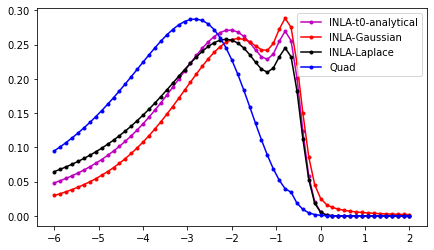

In [55]:
plt.figure(figsize=(7, 4))
plt.plot(
    ti_rule.pts, t0_analytical_p_ti_g_y, "m-o", markersize=3, label="INLA-t0-analytical"
)
plt.plot(ti_rule.pts, gaussian_p_ti_g_y, "r-o", markersize=3, label="INLA-Gaussian")
plt.plot(ti_rule.pts, laplace_p_ti_g_y, "k-o", markersize=3, label="INLA-Laplace")
plt.plot(ti_rule.pts, quad_p_ti_g_y[0], "b-o", markersize=3, label="Quad")
plt.legend()
plt.show()